© 2022 Rachel Banks and Soichi Hirokawa. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT) 

# Gillespie Simulations 

In [ ]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

%matplotlib inline


## Introduction ##

In this tutorial we will further extend our application of stochastic simulations and use a specific approach to such simulations known as the Gillespie algorithm. Gillespie simulations are particularly convenient because they guarantee that we will update the state of the system at each time step at the cost of recording how much time has transpired during each time step. A key part of the Gillespie simulation is that rather than asking over a fixed time interval $\Delta t$ whether a new event has occurred, we ask how long it takes for a new event to occur and then determine what the event is in order to update the state of the system. Examples of events might be the degradation of a molecule or the binding of a ligand to a sensory receptor on a bacterium. In the Gillespie simulation to follow, we will consider ligand-receptor binding, and there are only two steps:

 1. At time step $i+1$ in the simulation, obtain the time it took for the next event to occur since the $i$-th event by drawing from a probability distribution for the waiting time.
 2. Update the system based upon the rules of the event.

This process is iterated over many time steps, typically until the output seems to fluctuate about a steady state.

### Obtaining the waiting time ###

The first part of the Gillespie simulation involves determining when the event occurs. Suppose a particular event occurs stochastically with a rate $r$ and that after every $\Delta t$ we ask whether the event has occurred. For sufficiently small $\Delta t$, the probability of the event occurring in that time interval is $p = r \Delta t$. We could in principle simulate this by performing a coin flip similar to what we did in the diffusion stochastic simulation, but rather than determining whether the random number we drew is greater than or less than $0.5$, we would be asking whether it is greater than or less than $p$, where flip $< p$ means the event happened and flip $> p$ means nothing happened. This approach can become quite computationally wasteful, however, as we will have several time steps in a row where no event occurs and the system does not change. Instead, we can ask how long do we need to wait before the event occurs.

To do this, instead we consider that an event occurs after a waiting time $t \gg \Delta t$ such that $t \equiv N \Delta t$, where $N$ is the number of times we had to ask before the new event occurs. At each time step, the probability that the event *does not* happen is $p_{not} = 1 - r \Delta t$. In this case, the probability that the event does not occur for all $N$ time steps given the rate $r$ is 
\begin{equation}
  P \left(0\text{ events},\Delta t | r \right) = \left(1 - r \Delta t \right)^N. \tag{1}
\end{equation}

This can be rewritten as
\begin{equation}
  P \left(0 \text{ events}, t | r \right) = \left(1 - r \frac{t}{N} \right)^N. \tag{2}
\end{equation}

In the limit of very large N, or very small time intervals, such that $\frac{r t}{N} \ll 1$, we can approximate this as the exponential distribution. In this case, 

\begin{align}
  P \left(0 \text{ events},t | r \right) &\approx e^{- r t}. \tag{3}
\end{align}

We can see then that the probability distribution written in Eq. 3 is instead a function of $t$, $P \left(t | r \right)$. We can see from this derivation that $P \left( t | r \right)$ is the probability that it will take time $t$ for an event to occur. For our simulation, we wish to draw a waiting time from this distribution. 
Because $P \left(t | r \right)$ is a number with range [0,1), we can invert the probability distribution such that $P$ is obtained from the `numpy` pseudorandom number generator and can be used to obtain the time $t$. Thus, we obtain the waiting time $t$ by
\begin{equation}
  t = - \frac{\text{ln} \left( P \right)}{r}, \tag{4}
\end{equation}
where $P$ is obtained by the pseudorandom number generator. This will give us the time interval we needed to wait for the next event to occur.

### Updating the state of the system ###

In the second step, we must update the state of the system based upon the outcome event. In a system with two states A and B and only one way to go from one state to the other, the event is deterministic. That is, we can simply record that the new event is a simple switch to the opposite state. In our simulation of ligand-receptor binding, the receptor can either be in the bound or unbound state and we will be switching between the two. When we consider kinetic proofreading later, there will be more possible events in which we will resort to coin flipping or die rolling to decide which one occurs.

### Some additional notes ###

As with many stochastic simulations, it will be useful to examine the average over the individual trajectories for the quantities of interest. This means that many independent runs of the simulation must be performed to gain meaningful statistics and that the time variable, which is assembled from variable time intervals for individual runs, will need to be binned into the appropriate interval and the quantity of interest averaged according to the binning. Alternatively, as will be performed below, it can be useful to compute a particular value using the stored data, such as the fraction of time spent in a particular state, then compute the mean and variance from doing multiple runs.

We will now apply Gillespie simulations to the simple ligand-receptor binding case.

## Example 1: Ligand Binding ##

In this example, we will use Gillespie simulations of ligand-receptor binding to compute the probability that the receptor is bound, $p_\text{bound}$, as a function of the ligand concentration $L$. Suppose that we have a receptor with a single binding site that a single ligand can occupy and that the ligand can enter the binding site with rate $k_{on}$ (units of s$^{-1}$nM$^{-1}$) and exit at rate $k_{off}$ (units of s$^{-1}$). These two rates relate to the dissociation constant by $K_D = k_{off} / k_{on}$. We wish to investigate the probability $p_\text{bound}$ of the receptor being bound by any one of the $L$ ligands available to it. We will also look at how changing the parameters, namely the initial concentration of ligand and the rates of the system, affect the occupancies of the receptors and thus the value of $p_\text{bound}$.

First, we will define the rates and initial concentrations of molecules.

In [ ]:
# simulate ligand-receptor using Gillespie 
# define rate constants 
k_on = 1 # on-rate in units of per nM per s
k_d = 20 # dissociation constant in units of nM
k_off = k_on * k_d # off-rate

# initial concentration of ligand
c_l = k_d # concentration of ligand equal to k_d

# time steps for the simulation
n_steps = 10

# empty array into which transition times will be stored
ts = np.zeros(n_steps)

# empty array into which the occupancy of the receptor will be recorded
# 0 means the receptor is unoccupied while 1 means the receptor is occupied.
occupancy = np.zeros(n_steps)

Next, we will make the main loop for the simulation. Though we mentioned the steps for running the Gillespie simulation in the introduction to this tutorial, we will reiterate and elaborate on the steps in the context of this ligand-receptor example. In order to determine the concentration upon an event occurring at a time step $i>0$: 

1.   Determine the current state of the receptor.
2.   If the receptor is unbound, calculate the binding rate $r_{bind} = k_{on}[\text{L}]$. If the receptor is bound, compute the unbinding rate $r_{unbind} = k_{off}$.
3.   Draw out the interval of time to go from time step $i$ to $i+1$ using an exponential waiting time distribution with rate $r = r_{bind}$ if the receptor is unbound or $r = r_{unbind}$ if the receptor is bound.
4.   Update the occupancy of the receptor. Since the receptor can transition to only one other state, the occupancy of the receptor for the next time step is the opposite of what it currently is.

This process is iterated successively until all time steps are reached. Let's see this in action.

p_bound =  0.46196367722884074


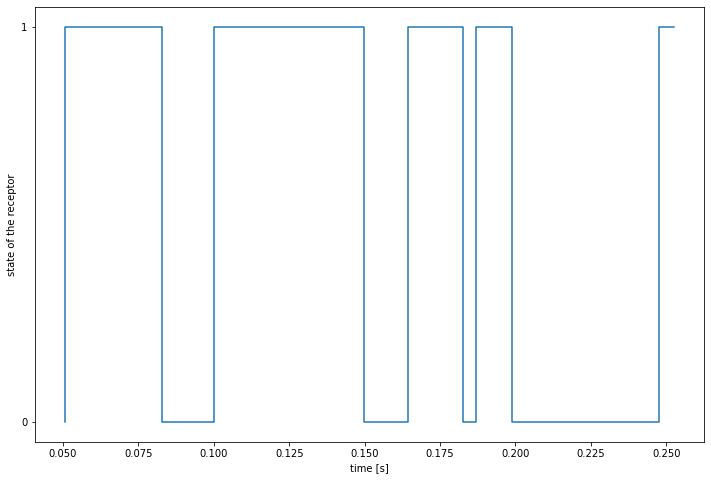

In [ ]:
# Since r_bind and r_unbind do not change in time, we will compute them out of the simulation.
r_bind = k_on * c_l
r_unbind = k_off

# main loop for running the simulation
for i in range(n_steps):

  current_state = occupancy[i]

  # calculate rates, these change based on the concentrations of free and bound receptors/ligands
  if current_state==0:
    r = r_bind
  elif current_state==1:
    r = r_unbind

  # determine the time when an event happens
  draw = np.random.rand()
  ts[i] = -np.log(draw) / r

  # the state of the receptor is the opposite of the previous state
  # notice that we use a for loop to avoid calling to an index beyond
  # the length of the vector
  if i < n_steps-1:
    occupancy[i+1] = 1 - current_state
      
# plot the results
# convert transition times into absolute time
times = np.cumsum(ts)

fig, ax = plt.subplots(1, 1, figsize = (12,8))

# plot number of bound receptors over time
ax.step(times, occupancy)
ax.set_xlabel('time [s]') 
ax.set_ylabel('state of the receptor')
ax.yaxis.set_ticks([0.0, 1.0])
ax.yaxis.set_ticklabels([0, 1])

time_bound = np.dot(ts, occupancy)
print('p_bound = ', time_bound / np.sum(ts))

As intended, the initially unbound receptor simply flips between the unbound (0) and bound (1) states. You can see that the transition times from one state to another are not equal by the design of drawing from an exponential distribution and that running the cell above will produce a different plot of the transition each time. Here, we immediately see the appeal of using Gillespie simulations: rather than setting a particular interval of time to ask whether a transition has occurred which can be computationally expensive, we simply draw the time it takes to transition and note that as well as the new state. Below the lines that plot the state of the receptor in time, we also computed the fraction of time spent in the bound state $p_{bound}$. Because we can think of the array containing the transition times and the array containing the occupancy as vectors, by taking their dot product, we can determine the total time in the bound state. When we divide by the total time, we get a $p_{bound}$. You might notice that $p_{bound}$ can change quite a bit each time we run the cell above. Let's instead look at more time steps, say 200 steps. For simplicity, we will create a function that carries out the `n_steps` of this Gillespie simulation. We will draw upon this function many times for the rest of this tutorial.

In [ ]:
def receptor_gillespie(r_bind, r_unbind, n_steps):
  # create new time step and occupancy arrays
  ts = np.zeros(n_steps)
  occupancy = np.zeros(n_steps)
  for i in range(n_steps):
    # calculate rates
    current_state = occupancy[i].copy()
    if current_state==0:
      r = r_bind
    elif current_state==1: 
      r = r_unbind
    
    # draw waiting time from rate-dependent exponential waiting time distribution
    draw = np.random.rand()
    ts[i] = -np.log(draw) / r

    if i < n_steps-1:
      occupancy[i+1] = 1 - current_state

  # determine time bound and total time to compute p_bound
  time_bound = np.dot(occupancy, ts)
  total_time = np.sum(ts)

  return time_bound / total_time

In [ ]:
n_steps = 200

# Specify initial ligand concentration and rates
c_l = k_d
r_bind = k_on * c_l
r_unbind = k_off

p_bound = receptor_gillespie(r_bind, r_unbind, n_steps)
print('p_bound = ', p_bound)

p_bound =  0.43669737759241056


Here, we can see that $p_{bound} \approx 0.5$. Let's repeat this simulation 100 times and compute the mean and standard deviation of $p_{bound}$ using the same number of steps as before.

In [ ]:
# do several runs of the simulation
n_runs = 100
n_steps = 200

# let's use the same concentration of ligand
c_l = k_d # concentration of ligand equal to k_d
r_bind = k_on * c_l
r_unbind = k_off

# record p_bound
p_bound = np.zeros(n_runs)

# loop through runs
for i in range(n_runs):
  p_bound[i] = receptor_gillespie(r_bind, r_unbind, n_steps)
  
print('p_bound = ', np.mean(p_bound), '±', np.std(p_bound))

p_bound =  0.4954965938759343 ± 0.035442737788758956


Here, we see that $p_{bound} \approx 0.5$. You might notice that this is the same as the ratio of $r_{bind}$ to the sum of $r_{bind}$ and $r_{unbind}$. This might be clearer when we consider the steady-state case from the master equation. We saw that starting from the chemical master equation for the concentration of bound receptors [LR]

\begin{equation}
  \frac{\text{d}[\text{LR}]}{\text{d}t} = k_{on}[\text{L}][\text{R}] - k_{off}[\text{LR}],\tag{4}
\end{equation}
for [L] the concentration of ligands, [R] the concentration of receptors, $k_{on}$ the on rate, and $k_{off}$ the off rate. At steady-state,

\begin{equation}
  [\text{LR}] = \frac{k_{on} [\text{L}][\text{R}]}{k_{off}},\tag{5}
\end{equation}
so the fraction of bound receptors (which is the number of bound receptors divided by the total number of receptors) is

\begin{align}
  f_\text{bound} &\equiv \frac{[\text{LR}]}{[\text{R}] + [\text{LR}]},\\
  &= \frac{\frac{k_{on} [\text{L}][\text{R}]}{k_{off}}}{[\text{R}] + \frac{k_{on} [\text{L}][\text{R}]}{k_{off}}},\\
  &= \frac{k_{on} [\text{L}]}{k_{off} + k_{on} [\text{L}]}.\tag{6}
\end{align}

Thus, we see that when we're looking at the single-receptor case, we should expect to see that the fraction of time spent in the bound state is equivalent to the fraction of bound receptors at steady-state. Let's run this simulation many times with different initial concentrations of ligands.

In [ ]:
n_parameters = 50
n_runs = 100
n_steps = 200

# Set different values of ligands
lig_conc = np.linspace(1, 30 * k_d, n_parameters)

# Let's make p_bound as n_parameters x n_runs
p_bound = np.zeros((n_parameters,n_runs))

for j in range(n_parameters):
  c_l = lig_conc[j]
  r_bind = k_on * c_l
  r_unbind = k_off

  for i in range(n_runs):
    p_bound[j,i] = receptor_gillespie(r_bind, r_unbind, n_steps)

([<matplotlib.axis.YTick at 0x7fdca3ae54d0>,
 <a list of 6 Text major ticklabel objects>)

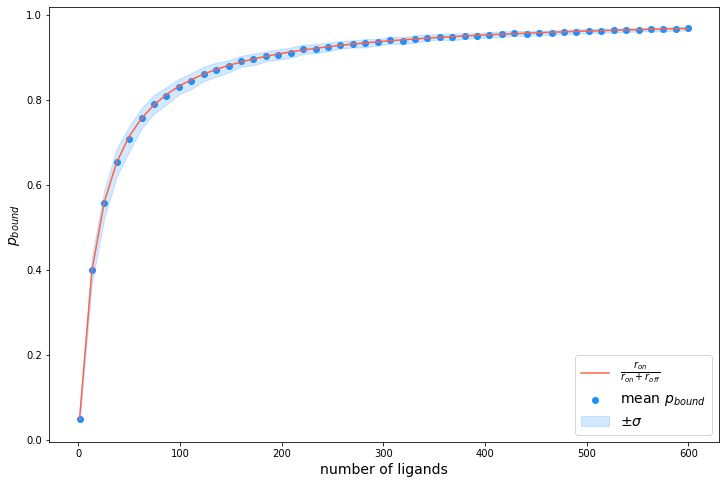

In [ ]:
# now let's plot the mean and standard deviation of p_bound for each concentration of ligand
p_mean = np.mean(p_bound, axis=1)
p_std = np.std(p_bound, axis=1)

plt.figure(figsize=(12,8))
plt.scatter(lig_conc, p_mean, color='dodgerblue', label=r'mean $p_{bound}$')
plt.fill_between(lig_conc, p_mean-p_std, p_mean+p_std, color='dodgerblue', alpha=0.2, label='±$\sigma$')

# we can similarly overlay the expected p_bound at different concentrations of ligand
p_expected = k_on * lig_conc / (k_off + k_on * lig_conc)
plt.plot(lig_conc, p_expected, color='tomato', label=r'$\frac{r_{on}}{r_{on} + r_{off}}$')
plt.legend(loc=4, fontsize=14)
plt.xlabel('number of ligands', fontsize=14)
plt.ylabel(r'$p_{bound}$', fontsize=14)
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])

We can see a nice agreement between the expected $p_{bound}$ and the fraction of time spent in the bound state. We saw here that using Gillespie simulations is convenient for examining ligand-receptor dynamics and allowed us to scan the a full suite of ligand concentrations and examine how such concentrations subsequently affect the probability of a receptor being bound. We will now utilize Gillespie simulations for a more complex but incredible feature of biology: kinetic proofreading.